100%|██████████| 9912422/9912422 [00:00<00:00, 64350717.01it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 19397228.79it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 23513203.08it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 17178114.31it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Data loaded successfully...


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[epoch 1, iter   200] loss: 1.101
[epoch 1, iter   400] loss: 0.177
[epoch 1, iter   600] loss: 0.111
[epoch 1, iter   800] loss: 0.090
epoch 1: train_acc 97.205, test_acc 97.090
[epoch 2, iter   200] loss: 0.071
[epoch 2, iter   400] loss: 0.073
[epoch 2, iter   600] loss: 0.067
[epoch 2, iter   800] loss: 0.051
epoch 2: train_acc 98.532, test_acc 98.390
[epoch 3, iter   200] loss: 0.049
[epoch 3, iter   400] loss: 0.041
[epoch 3, iter   600] loss: 0.045
[epoch 3, iter   800] loss: 0.041
epoch 3: train_acc 98.942, test_acc 98.510
[epoch 4, iter   200] loss: 0.032
[epoch 4, iter   400] loss: 0.041
[epoch 4, iter   600] loss: 0.037
[epoch 4, iter   800] loss: 0.040
epoch 4: train_acc 99.222, test_acc 98.680
[epoch 5, iter   200] loss: 0.031
[epoch 5, iter   400] loss: 0.029
[epoch 5, iter   600] loss: 0.026
[epoch 5, iter   800] loss: 0.034
epoch 5: train_acc 99.403, test_acc 98.790
[epoch 6, iter   200] loss: 0.024
[epoch 6, iter   400] loss: 0.026
[epoch 6, iter   600] loss: 0.022
[ep

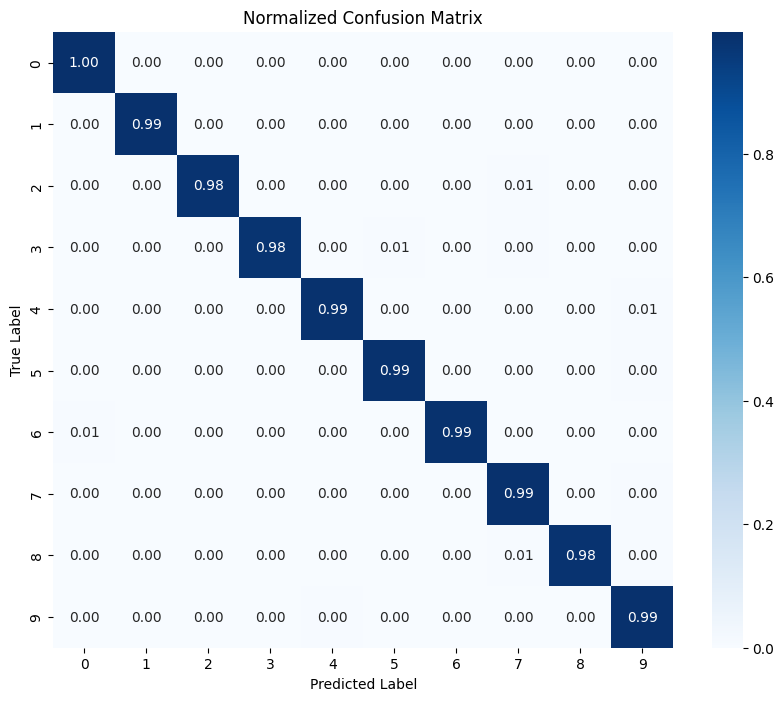

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision as tv
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

train_batch_size = 64
test_batch_size = 1000

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(6, 16, 5, stride=1, padding=0)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        x_size = x.size()[1:]
        num = 1
        for n in x_size:
            num *= n
        return num

def load_data():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_set = tv.datasets.MNIST(
        root='./data',
        train=True,
        download=True,
        transform=transform
    )
    train_loader = torch.utils.data.DataLoader(
        train_set,
        batch_size=train_batch_size,
        shuffle=True,
        num_workers=2
    )

    test_set = tv.datasets.MNIST(
        root='./data',
        train=False,
        download=True,
        transform=transform
    )
    test_loader = torch.utils.data.DataLoader(
        test_set,
        batch_size=test_batch_size,
        shuffle=False,
        num_workers=2
    )
    print("Data loaded successfully...")
    return train_loader, test_loader

def accuracy(model, x, neg=False):
    with torch.no_grad():
        correct = 0
        total = 0
        class_correct = list(0. for i in range(10))
        class_total = list(0. for i in range(10))
        for data in x:
            images, labels = data
            if neg:
                images = -images
            images, labels = images, labels
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        return (100 * correct / total)

def train(train_loader, test_loader, model, criterion, optimizer, epoch):
    model.train()
    running_loss = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs, labels
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 200 == 199:
            print("[epoch %d, iter %5d] loss: %.3f" % (epoch+1, i+1, running_loss/200))
            running_loss = 0.0
    train_acc = accuracy(model, train_loader)
    test_acc = accuracy(model, test_loader)
    print("epoch %d: train_acc %.3f, test_acc %.3f" % (epoch+1, train_acc, test_acc))
    return train_acc, test_acc

def display(train_acc, test_acc):
    fig, ax = plt.subplots()
    ax.plot(range(1, len(train_acc)+1), train_acc, color='r', label='train_acc')
    ax.plot(range(1, len(test_acc)+1), test_acc, color='b', label='test_acc')
    ax.legend(loc='lower right')
    plt.show()

def test(model, test_loader):
    model.eval()
    all_preds = torch.tensor([], dtype=torch.long).to(device)
    all_labels = torch.tensor([], dtype=torch.long).to(device)
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds = torch.cat((all_preds, preds), dim=0)
            all_labels = torch.cat((all_labels, labels), dim=0)
    return all_preds, all_labels

if __name__ == '__main__':
    train_loader, test_loader = load_data()
    net = Net()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net.to(device)

    learning_rate = 0.01
    momentum = 0.9
    max_epoch = 10
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)

    train_acc = []
    test_acc = []
    for epoch in range(max_epoch):
        train_acc_t, test_acc_t = train(train_loader, test_loader, net, criterion, optimizer, epoch)
        train_acc.append(train_acc_t)
        test_acc.append(test_acc_t)

    all_preds, all_labels = test(net, test_loader)
    conf_matrix = confusion_matrix(all_labels.cpu().numpy(), all_preds.cpu().numpy())
    conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Normalized Confusion Matrix')
    plt.show()


100%|██████████| 26421880/26421880 [00:02<00:00, 12834927.45it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 228287.59it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 4314754.29it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 22352253.61it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Data loaded successfully...


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[epoch 1, iter   200] loss: 0.897
[epoch 1, iter   400] loss: 0.575
[epoch 1, iter   600] loss: 0.488
[epoch 1, iter   800] loss: 0.438
epoch 1: train_acc 84.055, test_acc 83.120
[epoch 2, iter   200] loss: 0.392
[epoch 2, iter   400] loss: 0.365
[epoch 2, iter   600] loss: 0.376
[epoch 2, iter   800] loss: 0.358
epoch 2: train_acc 87.697, test_acc 86.480
[epoch 3, iter   200] loss: 0.334
[epoch 3, iter   400] loss: 0.325
[epoch 3, iter   600] loss: 0.306
[epoch 3, iter   800] loss: 0.312
epoch 3: train_acc 88.008, test_acc 86.860
[epoch 4, iter   200] loss: 0.286
[epoch 4, iter   400] loss: 0.285
[epoch 4, iter   600] loss: 0.287
[epoch 4, iter   800] loss: 0.285
epoch 4: train_acc 90.220, test_acc 88.640
[epoch 5, iter   200] loss: 0.276
[epoch 5, iter   400] loss: 0.263
[epoch 5, iter   600] loss: 0.258
[epoch 5, iter   800] loss: 0.253
epoch 5: train_acc 90.915, test_acc 88.920
[epoch 6, iter   200] loss: 0.249
[epoch 6, iter   400] loss: 0.249
[epoch 6, iter   600] loss: 0.236
[ep

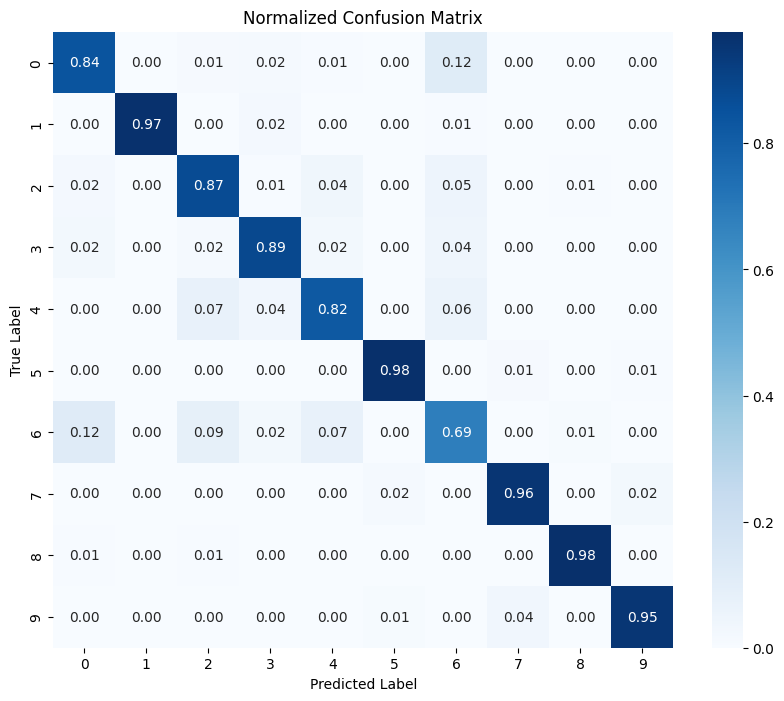

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision as tv
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

train_batch_size = 64
test_batch_size = 1000

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(6, 16, 5, stride=1, padding=0)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)  # Change from 10 to 10 for Fashion-MNIST
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    def num_flat_features(self, x):
        x_size = x.size()[1:]
        num = 1
        for n in x_size:
            num *= n
        return num

def load_data():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))  # Adjust normalization for Fashion-MNIST
    ])
    train_set = tv.datasets.FashionMNIST(
        root='./data',
        train=True,
        download=True,
        transform=transform
    )
    train_loader = torch.utils.data.DataLoader(
        train_set,
        batch_size=train_batch_size,
        shuffle=True,
        num_workers=2
    )
    test_set = tv.datasets.FashionMNIST(
        root='./data',
        train=False,
        download=True,
        transform=transform
    )
    test_loader = torch.utils.data.DataLoader(
        test_set,
        batch_size=test_batch_size,
        shuffle=False,
        num_workers=2
    )
    print("Data loaded successfully...")
    return train_loader, test_loader

def accuracy(model, x):
    with torch.no_grad():
        correct = 0
        total = 0
        for data in x:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        return (100 * correct / total)

def train(train_loader, test_loader, model, criterion, optimizer, epoch):
    model.train()
    running_loss = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 200 == 199:
            print("[epoch %d, iter %5d] loss: %.3f" % (epoch+1, i+1, running_loss / 200))
            running_loss = 0.0
    train_acc = accuracy(model, train_loader)
    test_acc = accuracy(model, test_loader)
    print("epoch %d: train_acc %.3f, test_acc %.3f" % (epoch+1, train_acc, test_acc))
    return train_acc, test_acc

def display(train_acc, test_acc):
    fig, ax = plt.subplots()
    ax.plot(range(1, len(train_acc) + 1), train_acc, color='r', label='train_acc')
    ax.plot(range(1, len(test_acc) + 1), test_acc, color='b', label='test_acc')
    ax.legend(loc='lower right')
    plt.show()

def test(model, test_loader):
    model.eval()
    all_preds = torch.tensor([], dtype=torch.long).to(device)
    all_labels = torch.tensor([], dtype=torch.long).to(device)
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds = torch.cat((all_preds, preds), dim=0)
            all_labels = torch.cat((all_labels, labels), dim=0)
    return all_preds, all_labels

if __name__ == '__main__':
    train_loader, test_loader = load_data()
    net = Net()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net.to(device)

    learning_rate = 0.001
    momentum = 0.9
    max_epoch = 90
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)

    train_acc = []
    test_acc = []
    for epoch in range(max_epoch):
        train_acc_t, test_acc_t = train(train_loader, test_loader, net, criterion, optimizer, epoch)
        train_acc.append(train_acc_t)
        test_acc.append(test_acc_t)

    all_preds, all_labels = test(net, test_loader)
    conf_matrix = confusion_matrix(all_labels.cpu().numpy(), all_preds.cpu().numpy())

    # Normalize the confusion matrix
    conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Normalized Confusion Matrix')
    plt.show()
